<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

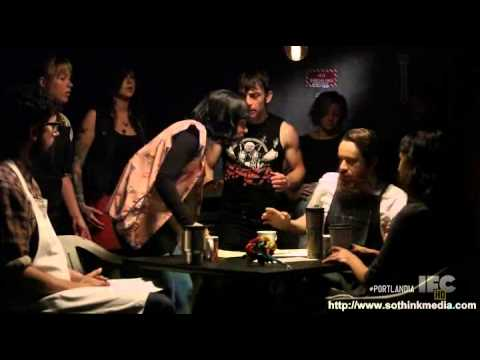

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\Loren\\OneDrive\\Code\\LambdaSchool\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [4]:
# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
#     tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = text
    tokens = tokens.lower().split()
    
    return tokens

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [5]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

STOP_WORDS = nlp.Defaults.stop_words.union(['I','i', '1', '', ' ','-', "it's", 'it.', 'the', "i'm", "i've", 'this', 'star', 'rating', 'coffee', 'place', 'check-in'])

# Tokenizer Pipe
tokens = []
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
    doc_tokens.pop(0)
#     doc_tokens.remove('check-in')
    tokens.append(doc_tokens)
shops['tokens'] = tokens
shops['rating_num'] = shops['star_rating'].str.slice(stop=4).astype(float)
shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens,rating_num
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[love, love, loved, atmosphere!, corner, shop,...",5.0
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[listed, date, night:, austin,, ambiance, aust...",4.0
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[listed, brunch, spots, loved, eclectic, homey...",4.0
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[cool, decor!, good, drinks, nice, seating, ho...",2.0
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[located, northcross, mall, shopping, center, ...",4.0


In [6]:
wc = count(shops['tokens'])
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
152,great,2438,3250,1.0,0.008790,0.008790,0.320116
167,like,2034,2902,2.0,0.007849,0.016638,0.267069
173,good,2084,2779,3.0,0.007516,0.024154,0.273634
18,love,1434,1806,4.0,0.004884,0.029039,0.188288
791,little,1230,1479,5.0,0.004000,0.033039,0.161502
366,don't,1133,1395,6.0,0.003773,0.036812,0.148766
163,nice,1188,1368,7.0,0.003700,0.040512,0.155987
393,food,1092,1363,8.0,0.003686,0.044198,0.143382
605,time,1099,1345,9.0,0.003638,0.047836,0.144301
0,pretty,1066,1339,10.0,0.003621,0.051457,0.139968


In [7]:
good_shops = shops[shops['rating_num'] >= 4.0]
bad_shops = shops[shops['rating_num'] < 4.0]

print("Word count for good coffe shops:")
good_words = count(good_shops['tokens'])
bad_words = count(bad_shops['tokens'])

Word count for good coffe shops:


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [15]:
words = []
differences = []

for word in count(shops['tokens'])['word'].to_list():
    words.append(word)
    
# good_pct = good_words[good_words['word'] == 'great']['appears_in_pct'].iloc[0]
# print(good_pct)
    
for word in words:
    try:
        good_pct = good_words[good_words['word'] == word]['appears_in_pct'].iloc[0]
    except IndexError:
        good_pct = 0
        
    try:
        bad_pct = bad_words[bad_words['word'] == word]['appears_in_pct'].iloc[0]
    except IndexError:
        bad_pct = 0
        
    difference = good_pct - bad_pct
#     print(word + ":", difference)
    differences.append(difference)
    
word_differences = pd.DataFrame({'word': words, 'difference': differences})

word_differences.head()

,word,difference
0,great,0.175210
1,like,-0.129254
2,good,-0.031191
3,love,0.089847
4,little,0.029730


In [17]:
worst_words = word_differences.sort_values(by=['difference']).head(10)['word'].to_list()
print(worst_words)

['like', "don't", 'service', "didn't", 'asked', 'ordered', "wasn't", 'maybe', 'pretty', 'better']


In [18]:
best_words = word_differences.sort_values(by=['difference'], ascending=False).head(10)['word'].to_list()
print(best_words)

['great', 'best', 'love', 'check-ins', 'friendly', 'delicious', 'definitely', 'perfect', 'favorite', 'super']


In [27]:
wc_good = count(good_shops['tokens'])
wc_good = wc_good[wc_good['word'].isin(best_words)]

wc_bad = count(bad_shops['tokens'])
wc_bad = wc_bad[wc_bad['word'].isin(worst_words)]

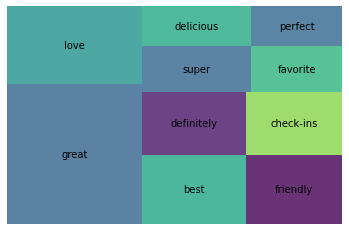

In [28]:
import squarify
import matplotlib.pyplot as plt

squarify.plot(sizes=wc_good['pct_total'], label=wc_good['word'], alpha=.8 )
plt.axis('off')
plt.show()

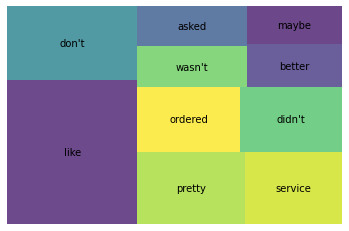

In [29]:
squarify.plot(sizes=wc_bad['pct_total'], label=wc_bad['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

